In [1]:
import sys
import geopandas as gpd
import multiprocessing
import numpy as np 

sys.path.append('../utils')
import data_paths
from traffic_counts import TrafficCounts
from hbefa_hot_emissions import HbefaHotEmissions
from excel_calendar import Calendar
from gridding import GriddingEngine

import inventory_processing

In [2]:
# import visum model
visum = gpd.read_file(data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg')
visum_red = visum.drop(visum.loc[(visum['road_type'] == 'none') | (visum['dtv_SUM']<1)].index, axis = 0) # drop useless columns

visum_red.loc[visum_red['road_type']=='Access-residential', 'road_type'] = 'Local/Collector'
visum_red.loc[visum_red['road_type']=='Distributor/Secondary', 'road_type'] = 'TrunkRoad/Primary-National'

In [3]:
# cut visum model to the Munich area
munich_boarders = gpd.read_file(data_paths.MUNICH_BOARDERS_FILE).to_crs(25832)
visum_red = gpd.clip(visum_red, munich_boarders)

In [4]:
# initialize calendar
cal = Calendar()
# initialize traffic cycles
cycles = TrafficCounts()
# initialize HBEFA emission factors
hbefa = HbefaHotEmissions()

Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_PC.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_LCV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_HGV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_Coach.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_MOT.XLS


In [5]:
# get dates for normweekdays in 2019
dates = cal.get_calendar()
normweekdays_2019 = dates[(dates['day_type'] == 1) &
                          (dates['date'].between('2019-01-01','2019-12-31'))]

# calculate vehicle shares on average norm weekday in 2019
# these values are used to calculate the vehicle share correction factors
weekday_shares_2019 = cycles.vehicle_shares.loc[:,normweekdays_2019['date']].reset_index()
weekday_shares_2019 = weekday_shares_2019.groupby(['road_type','vehicle_class'])[0].mean()

In [6]:
visum_red['hgv_corr'] = visum_red.apply(lambda row : row['delta_HGV'] / weekday_shares_2019.loc[row['road_type'],'HGV'], axis = 1)
visum_red['lcv_corr'] = visum_red.apply(lambda row : row['delta_LCV'] / weekday_shares_2019.loc[row['road_type'],'LCV'], axis = 1)

In [14]:
#NUMBER_OF_PROCESSES = multiprocessing.cpu_count()
NUMBER_OF_PROCESSES = 7
df = cal.get_calendar()
dates = [d.strftime("%Y-%m-%d") for d in df[df['date'].between('2019-01-01','2019-01-31')]['date']]

visum_red = visum_red.reset_index(drop = True).reset_index()

parameters = [(d,visum_red.to_dict('records'), cycles, hbefa, False) for d in dates]

with multiprocessing.Pool(NUMBER_OF_PROCESSES) as pool:
    res = pool.starmap(inventory_processing.calculate_daily_co2_emissions, parameters)

Cannot process 2019-01-01
Error: 'Local/Collector'
Finished 2019-01-03
Finished 2019-01-02
Finished 2019-01-05
Finished 2019-01-07
Finished 2019-01-09
Finished 2019-01-11
Finished 2019-01-13
Finished 2019-01-04
Finished 2019-01-06
Finished 2019-01-08
Finished 2019-01-15
Finished 2019-01-10
Finished 2019-01-12
Finished 2019-01-14
Finished 2019-01-17
Finished 2019-01-16
Finished 2019-01-19
Finished 2019-01-21
Finished 2019-01-23
Finished 2019-01-25
Finished 2019-01-18
Finished 2019-01-27
Finished 2019-01-20
Finished 2019-01-29
Finished 2019-01-22
Finished 2019-01-24
Finished 2019-01-26
Finished 2019-01-28
Finished 2019-01-31
Finished 2019-01-30


In [15]:
emission_dict = {index:0 for index in visum_red['index'].unique()}

for item in res: 
    if item == 0:
        continue
    else:
        # we have data to process
        for key, value in item.items():
            sum_emission = sum([k for k in value.values() if k == k])
            emission_dict[key] += sum_emission
    

In [16]:
visum_red['emissions'] = visum_red['index'].map(emission_dict)

visum_plot = visum_red.groupby('road_link_id').agg({'emissions': 'sum', 'geometry': (lambda x: x.iloc[0])})

visum_plot = gpd.GeoDataFrame(visum_plot,  geometry=visum_plot['geometry'], crs = 25832)

/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_7062/1325238765.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  visum_plot.plot(ax=ax, column = 'emissions', cmap = matplotlib.cm.get_cmap('twilight_shifted'), norm=matplotlib.colors.LogNorm())


<Axes: >

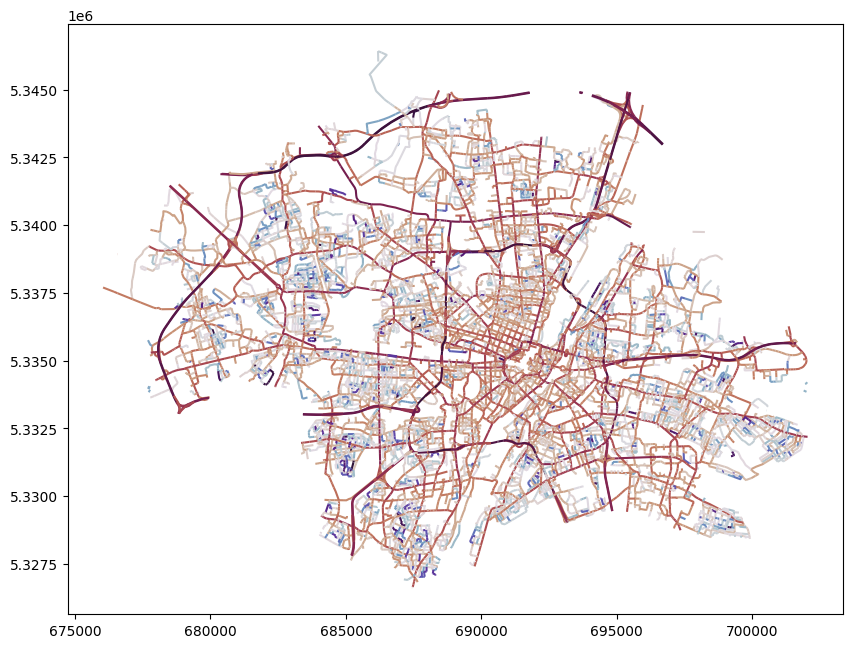

In [17]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(figsize = (10,10), frameon=False)
visum_plot.plot(ax=ax, column = 'emissions', cmap = matplotlib.cm.get_cmap('twilight_shifted'), norm=matplotlib.colors.LogNorm())

In [18]:
#boundaries derived from uba inventory
xmin = 675000
xmax = 703000
ymin = 5325800
ymax = 5347800



path = "/Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/geodata/TNO_100m_grid.gpkg"
in_grid = gpd.read_file(path)
in_grid = in_grid.to_crs(25832)

grd = GriddingEngine(input_grid=in_grid)

In [19]:
data_geo = gpd.overlay(visum_plot, 
                            grd.grid, 
                            how = 'intersection', 
                            keep_geom_type=True)

#Calculate total road length (PROXY) for each segment cut off by the output grid
data_geo['PROXY'] = data_geo.geometry.length

data_geo['emissions'] = data_geo['emissions'].astype('float') * data_geo['PROXY']

data_geo['CENTROID'] = data_geo.geometry.centroid # use centroid for exact assignment
data_geo = data_geo.set_geometry('CENTROID')
gridded_aux = gpd.sjoin(grd.grid, data_geo, how="right", predicate='contains')

em_grouped = gridded_aux.groupby('index_left').sum(numeric_only = True)

grd.grid['emissions'] = em_grouped['emissions']

grd.grid = grd.grid.fillna(0)

/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_7062/3666954359.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  grd.grid.plot(ax=ax, column = 'emissions', cmap = matplotlib.cm.get_cmap('twilight_shifted'), norm=matplotlib.colors.LogNorm())


<Axes: >

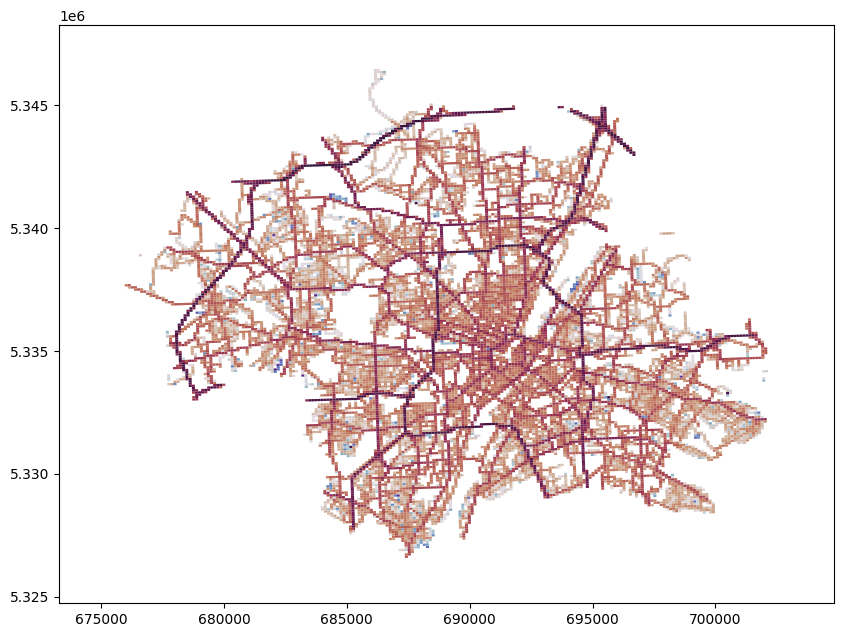

In [21]:
fig, ax  = plt.subplots(figsize = (10,10), frameon=False)
grd.grid.plot(ax=ax, column = 'emissions', cmap = matplotlib.cm.get_cmap('twilight_shifted'), norm=matplotlib.colors.LogNorm())

In [26]:
grd.grid['emissions'].sum()*1e-12

101.79041372439822